# TESLA Stock Market Prediction with LSTM

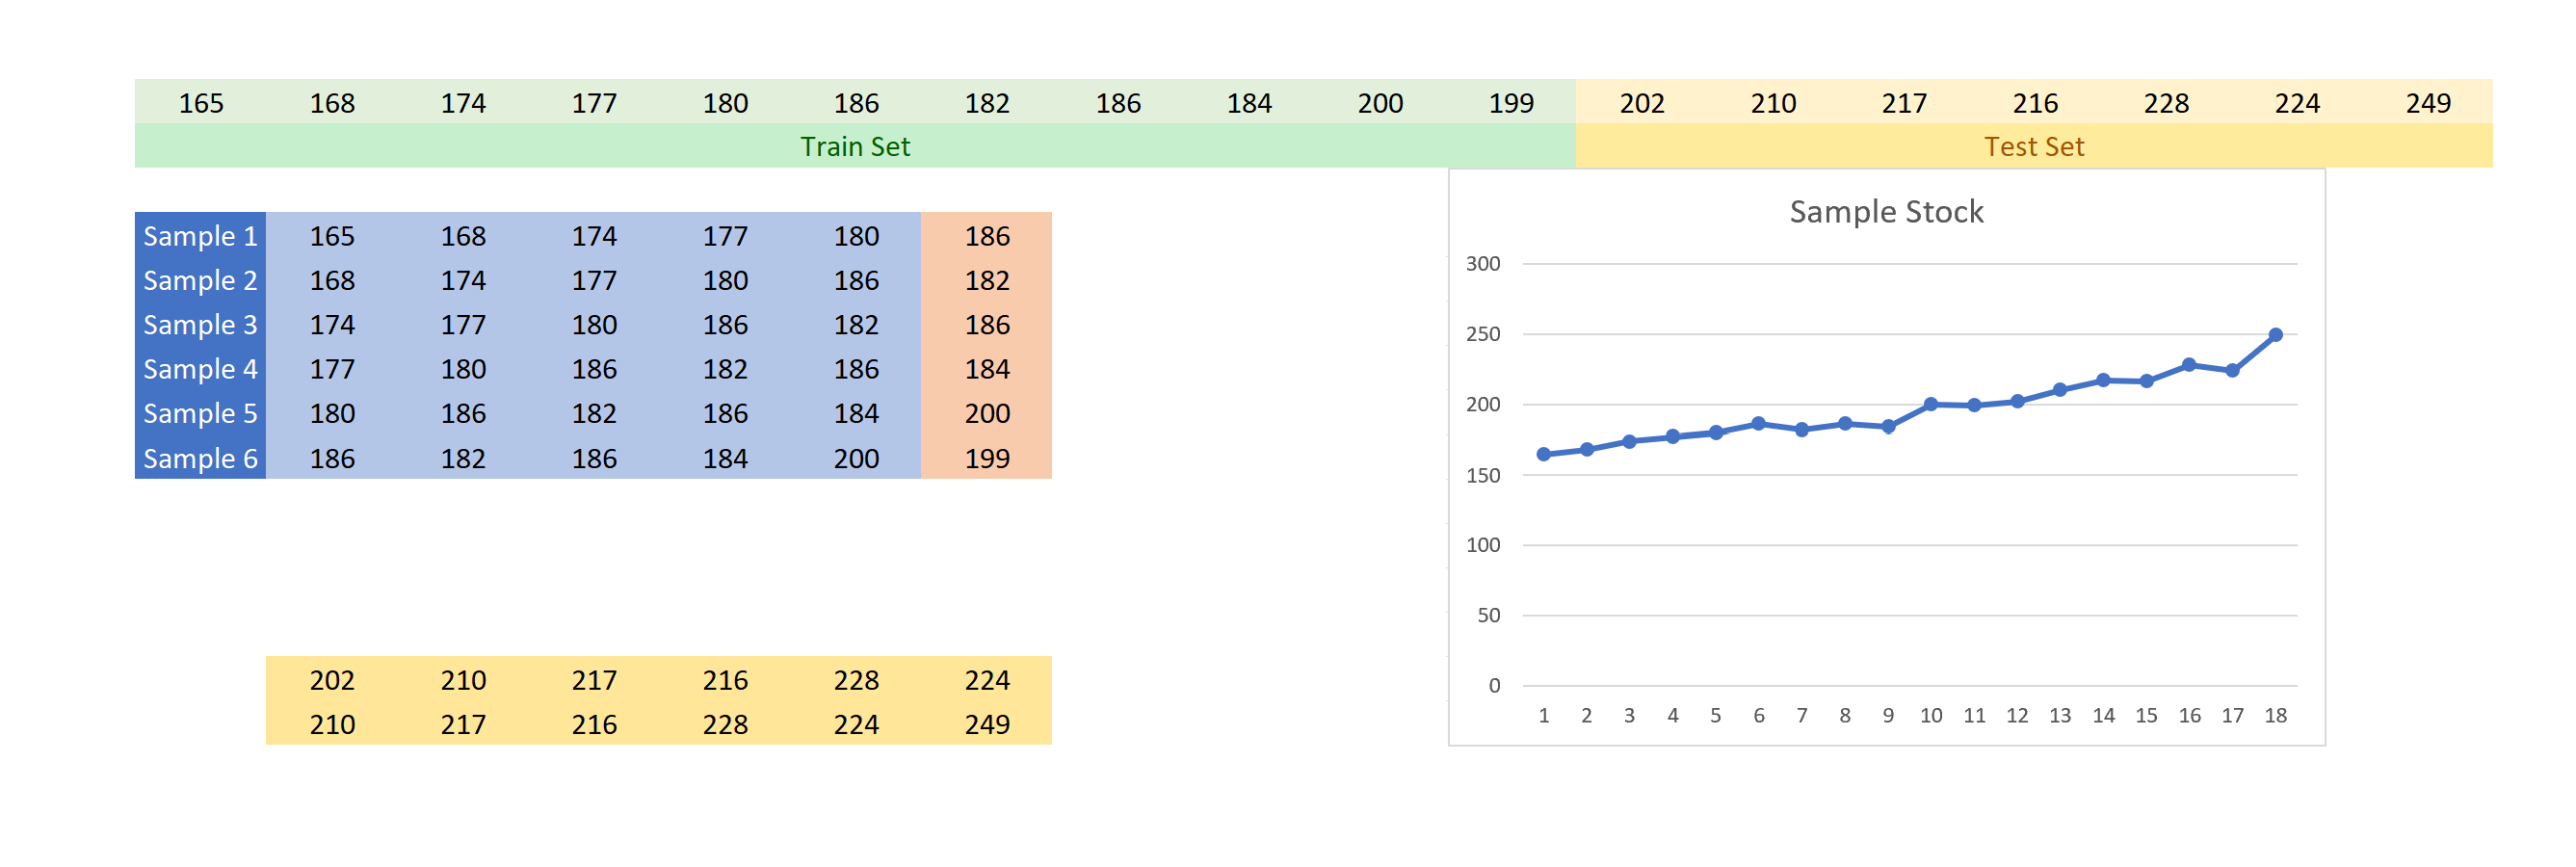

- **Data Collection:** Gather historical stock market data from reliable sources, ensuring it includes essential features like date, open price, high price, low price, closing price, and volume. | `yfinance`
- **Data Preprocessing:** Clean the data by removing missing values and outliers, and normalize numerical features to a common scale to improve the LSTM model's convergence and performance.
- **Data Windowing:** Create data windows of size 5, where each window consists of 5 consecutive trading days as input features and the closing price of the 6th day as the target value.
- **Train-Test Split:** Split the data into training and testing sets, allocating around 80% for training and 20% for testing, while maintaining the temporal order of the data.
- **Reshape Data for LSTM:** Reshape the input data into a 3D array with dimensions (batch_size, time_steps, num_features) to match the expected input shape of the LSTM model, where time steps are 5 (window size) and num_features represent the input features.


## 1.Loading Data


We will download and predict `TESLA` share.

https://www.google.com/search?q=tesla+share

In [52]:
# !pip install yfinance


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [54]:
import yfinance as yf

In [55]:
start_date = '2010-01-01'
end_date = '2023-07-01'

df = yf.download('TSLA', start=start_date, end=end_date).reset_index()

[*********************100%***********************]  1 of 1 completed


In [56]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [57]:
data = df['Open'].tolist()

length_data = len(data)
split_ration = 0.7
length_train = round(length_data*split_ration)
length_data, length_train

(3274, 2292)

In [58]:
train_data = data[:length_train]
test_data = data[length_train:]

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data = np.array(train_data).reshape(-1, 1)
test_data = np.array(test_data).reshape(-1, 1)

In [60]:
train_data.shape, test_data.shape

((2292, 1), (982, 1))

In [61]:
train_data_scaled = scaler.fit_transform(train_data).flatten()
test_data_scaled = scaler.fit_transform(test_data).flatten()

In [62]:
# test_data_scaled

## Dataset Windowing

In [63]:
train_data_scaled

array([0.00771827, 0.02604236, 0.02391042, ..., 0.58078532, 0.57606264,
       0.58221564])

In [64]:
window_size=50

def windowed_dataset(data, window_size):
  X, y = [], []
  for i in range(len(data)-window_size-1):
    X.append(data[i:(i+window_size)])
    y.append(data[i+window_size])

  return np.array(X), np.array(y)

In [65]:
X_train, y_train = windowed_dataset(train_data_scaled, window_size)
X_test, y_test = windowed_dataset(test_data_scaled, window_size)

In [66]:
X_train

array([[0.00771827, 0.02604236, 0.02391042, ..., 0.0127648 , 0.01206315,
        0.01219807],
       [0.02604236, 0.02391042, 0.01851301, ..., 0.01206315, 0.01219807,
        0.01311564],
       [0.02391042, 0.01851301, 0.01041694, ..., 0.01219807, 0.01311564,
        0.01244095],
       ...,
       [0.49013629, 0.49375251, 0.48090678, ..., 0.56928888, 0.58496829,
        0.61222511],
       [0.49375251, 0.48090678, 0.49572256, ..., 0.58496829, 0.61222511,
        0.61128052],
       [0.48090678, 0.49572256, 0.47243288, ..., 0.61222511, 0.61128052,
        0.58078532]])

In [67]:
y_train

array([0.01311564, 0.01244095, 0.0128188 , ..., 0.61128052, 0.58078532,
       0.57606264])

<a id="6"></a>
## 6.Creating RNN model

In [68]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [69]:
model =Sequential()
model.add(LSTM(units=window_size, activation='tanh', return_sequences=True,
               input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=window_size, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=window_size, activation='tanh'))

model.add(Dense(1))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trai

In [71]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])

In [72]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
71/71 [==============================] - 14s 96ms/step - loss: 0.0516 - mae: 0.2712
Epoch 2/50
71/71 [==============================] - 6s 87ms/step - loss: 0.0253 - mae: 0.1908
Epoch 3/50
71/71 [==============================] - 9s 128ms/step - loss: 0.0167 - mae: 0.1545
Epoch 4/50
71/71 [==============================] - 7s 100ms/step - loss: 0.0091 - mae: 0.1127
Epoch 5/50
71/71 [==============================] - 6s 83ms/step - loss: 0.0042 - mae: 0.0762
Epoch 6/50
71/71 [==============================] - 7s 100ms/step - loss: 0.0022 - mae: 0.0524
Epoch 7/50
71/71 [==============================] - 6s 82ms/step - loss: 0.0016 - mae: 0.0414
Epoch 8/50
71/71 [==============================] - 7s 100ms/step - loss: 0.0015 - mae: 0.0378
Epoch 9/50
71/71 [==============================] - 6s 83ms/step - loss: 0.0015 - mae: 0.0376
Epoch 10/50
71/71 [==============================] - 7s 100ms/step - loss: 0.0015 - mae: 0.0377
Epoch 11/50
71/71 [==============================] - 

<a id="7"></a>
## 7.Evaluating Model

In [73]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

30/30 [==============================] - 2s 24ms/step


In [74]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

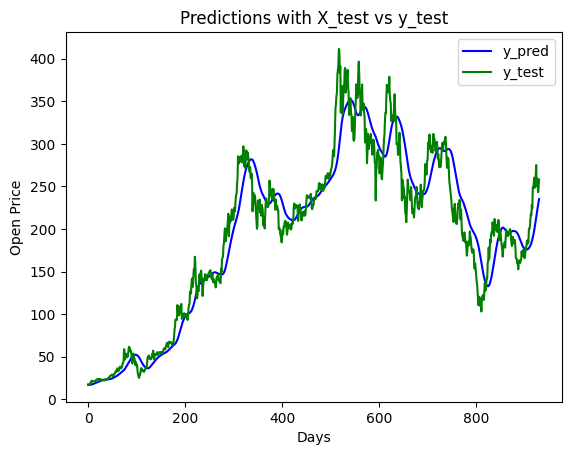

In [75]:
plt.plot(y_pred, color='b', label='y_pred')
plt.plot(y_test, color='g', label='y_test')
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.title("Predictions with X_test vs y_test")
plt.legend()
plt.show()

## Model Save and Load

In [77]:
import pickle
model.save('model.h5')
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [78]:
from keras.models import load_model

model1 = load_model('model.h5')
scaler1 = pickle.load(open("scaler.pkl", "rb"))